### Imports

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from sklearn.impute import KNNImputer

### Configuration

In [14]:
EXPERIMENT = "tara"
ACTIVITIES = ["relaxing", "eating", "walking", "studying"]
simple_distance_based_outlier_columns = [
    'accel_z', 'accel_y', 'accel_x',
    'gyro_z', 'gyro_y', 'gyro_x',
    'magne_z', 'magne_y', 'magne_x',
]
local_outlier_factor_columns = [
    'gps_altitude', 'gps_latitude', 'gps_longitude',
    'gravity_z', 'gravity_y', 'gravity_x',
    'bar_relativeAltitude', 'bar_pressure',
    'ori_qz', 'ori_qy', 'ori_qx', 'ori_qw'
]

### Dataset

In [8]:
dataset: pd.DataFrame = pd.read_csv(f"datasets/{EXPERIMENT}.csv")
dataset.columns.values[0] = "time"
print(dataset.columns)
dataset

Index(['time', 'accel_z', 'accel_y', 'accel_x', 'gyro_z', 'gyro_y', 'gyro_x',
       'gravity_z', 'gravity_y', 'gravity_x', 'ori_qz', 'ori_qy', 'ori_qx',
       'ori_qw', 'magne_z', 'magne_y', 'magne_x', 'bar_relativeAltitude',
       'bar_pressure', 'gps_altitude', 'gps_latitude', 'gps_longitude',
       'relaxing', 'eating', 'walking', 'studying'],
      dtype='object')


,time,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,gravity_z,gravity_y,gravity_x,...,magne_x,bar_relativeAltitude,bar_pressure,gps_altitude,gps_latitude,gps_longitude,relaxing,eating,walking,studying
0,2023-06-08 10:02:14.428471800,-0.004068,0.033979,-0.027080,-0.051672,0.075464,-0.011046,-7.343450,-6.471474,-0.457445,...,4.546346,-0.042274,1017.524719,41.925382,52.045397,4.384513,0,0,0,0
1,2023-06-08 10:02:15.428471800,0.046718,-0.051833,0.007038,0.005975,-0.041301,0.006421,-7.587952,-6.207840,-0.224354,...,5.082871,-0.084553,1017.529984,41.930438,52.045389,4.384509,0,0,0,0
2,2023-06-08 10:02:16.428471800,0.258378,0.015733,-0.086734,0.292964,0.487526,-0.174606,-7.115600,-6.463938,-1.046507,...,10.147813,-0.084553,1017.529984,41.877450,52.045384,4.384505,0,0,0,0
3,2023-06-08 10:02:17.428471800,-0.388019,-0.656673,0.409764,-0.058768,0.024429,-0.334667,-9.386129,-2.428225,0.830423,...,18.734642,-0.031708,1017.523575,41.843560,52.045386,4.384503,0,0,0,0
4,2023-06-08 10:02:18.428471800,0.181126,0.652100,0.148817,-0.114041,-0.001110,0.078117,-9.671041,-1.264088,-0.085595,...,13.000465,0.155897,1017.500992,41.886054,52.045386,4.384501,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21599,2023-06-08 16:02:13.428471800,-0.021761,0.002616,0.002799,0.000822,-0.002059,0.015809,0.609068,-9.656272,-1.598371,...,11.238202,20.419849,1015.060806,41.477542,52.045441,4.384580,1,0,0,0
21600,2023-06-08 16:02:14.428471800,0.014316,0.002327,-0.003718,0.014287,0.011617,0.026606,0.848866,-9.622351,-1.686895,...,10.879721,20.430418,1015.059662,41.477542,52.045441,4.384580,1,0,0,0
21601,2023-06-08 16:02:15.428471800,0.009734,0.003723,-0.005396,-0.012023,-0.035512,0.037696,1.123775,-9.595271,-1.669564,...,10.876070,NaN,NaN,41.486357,52.045444,4.384573,1,0,0,0
21602,2023-06-08 16:02:16.428471800,-0.001886,0.009764,0.005781,-0.012753,-0.005079,-0.044107,1.032805,-9.629271,-1.538645,...,11.351871,NaN,NaN,NaN,NaN,NaN,1,0,0,0


### Visualization

#### Overview

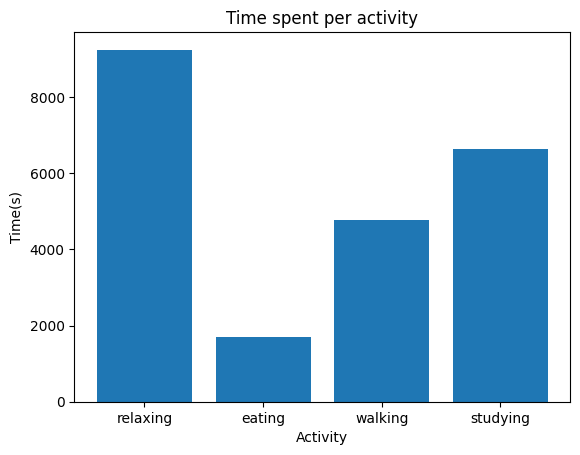

In [3]:
activities_count: pd.DataFrame = pd.DataFrame(
    dataset[ACTIVITIES].sum(),
    columns=['Sum']
)

plt.bar(activities_count.index, activities_count['Sum'])
plt.xlabel('Activity')
plt.ylabel('Time(s)')
plt.title('Time spent per activity')
plt.show()

#### Accelerometer

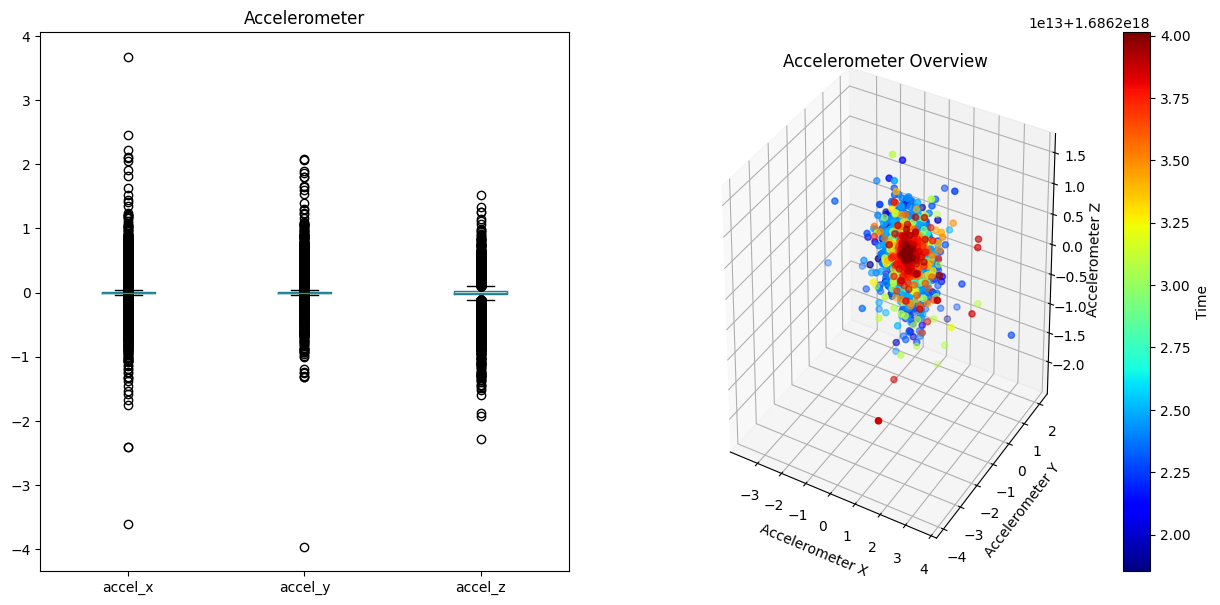

In [4]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# -------- Box plot
dataset[['accel_x', 'accel_y', 'accel_z']].plot.box(ax=ax1)
ax1.set_title("Accelerometer")

# -------- Scatter plot
sc = ax2.scatter(
    dataset['accel_x'],
    dataset['accel_y'],
    dataset['accel_z'],
    c=pd.to_datetime(dataset['time']).astype(int),
    cmap=cm.jet
)
ax2.set_xlabel('Accelerometer X')
ax2.set_ylabel('Accelerometer Y')
ax2.set_zlabel('Accelerometer Z')
ax2.set_title('Accelerometer Overview')
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Time')
plt.show()

#### Gravity

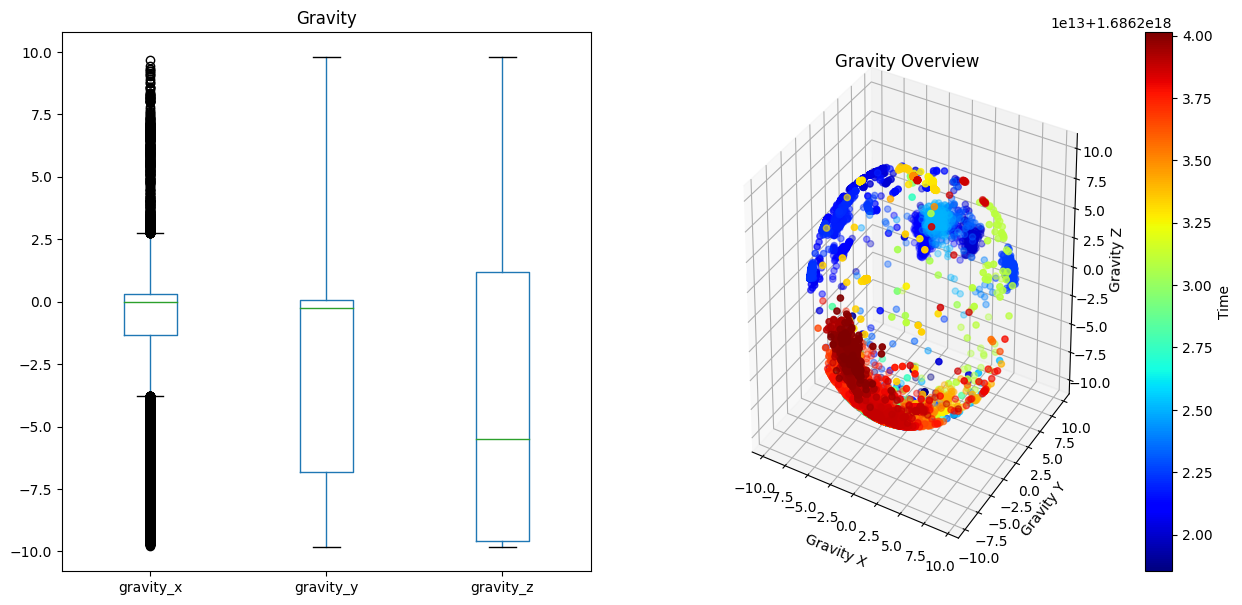

In [5]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# -------- Box plot
dataset[['gravity_x', 'gravity_y', 'gravity_z']].plot.box(ax=ax1)
ax1.set_title("Gravity")

# -------- Scatter plot
sc = ax2.scatter(
    dataset['gravity_x'],
    dataset['gravity_y'],
    dataset['gravity_z'],
    c=pd.to_datetime(dataset['time']).astype(int),
    cmap=cm.jet
)
ax2.set_xlabel('Gravity X')
ax2.set_ylabel('Gravity Y')
ax2.set_zlabel('Gravity Z')
ax2.set_title('Gravity Overview')
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Time')
plt.show()

#### Gyroscope

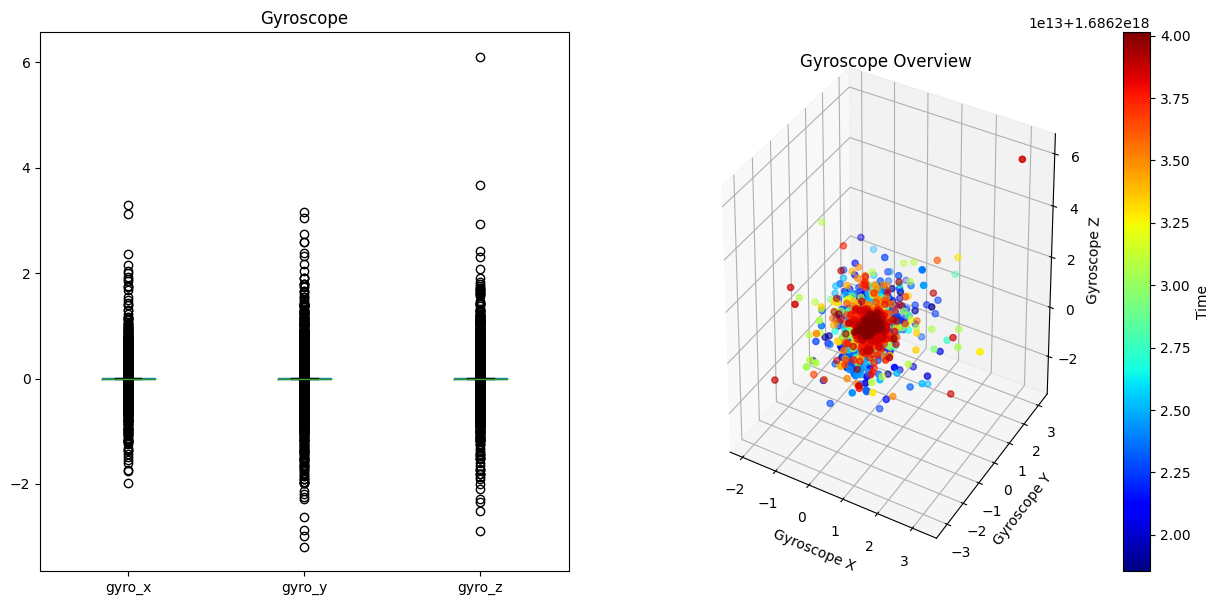

In [6]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# -------- Box plot
dataset[['gyro_x', 'gyro_y', 'gyro_z']].plot.box(ax=ax1)
ax1.set_title("Gyroscope")

# -------- Scatter plot
sc = ax2.scatter(
    dataset['gyro_x'],
    dataset['gyro_y'],
    dataset['gyro_z'],
    c=pd.to_datetime(dataset['time']).astype(int),
    cmap=cm.jet
)
ax2.set_xlabel('Gyroscope X')
ax2.set_ylabel('Gyroscope Y')
ax2.set_zlabel('Gyroscope Z')
ax2.set_title('Gyroscope Overview')
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Time')
plt.show()

#### Orientation

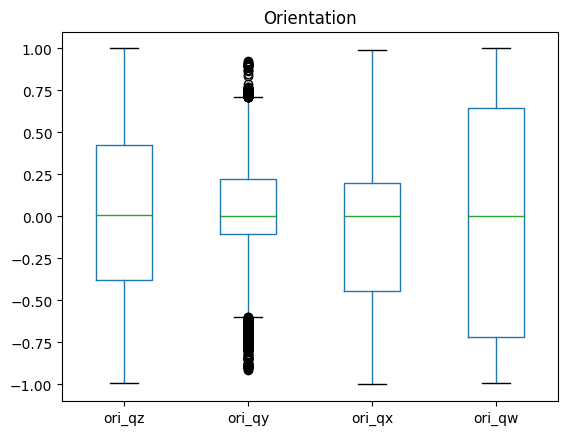

In [7]:
plt.Figure()
dataset[["ori_qz", "ori_qy", "ori_qx", "ori_qw"]].plot.box()
plt.title("Orientation")
plt.show()

#### Magnetometer

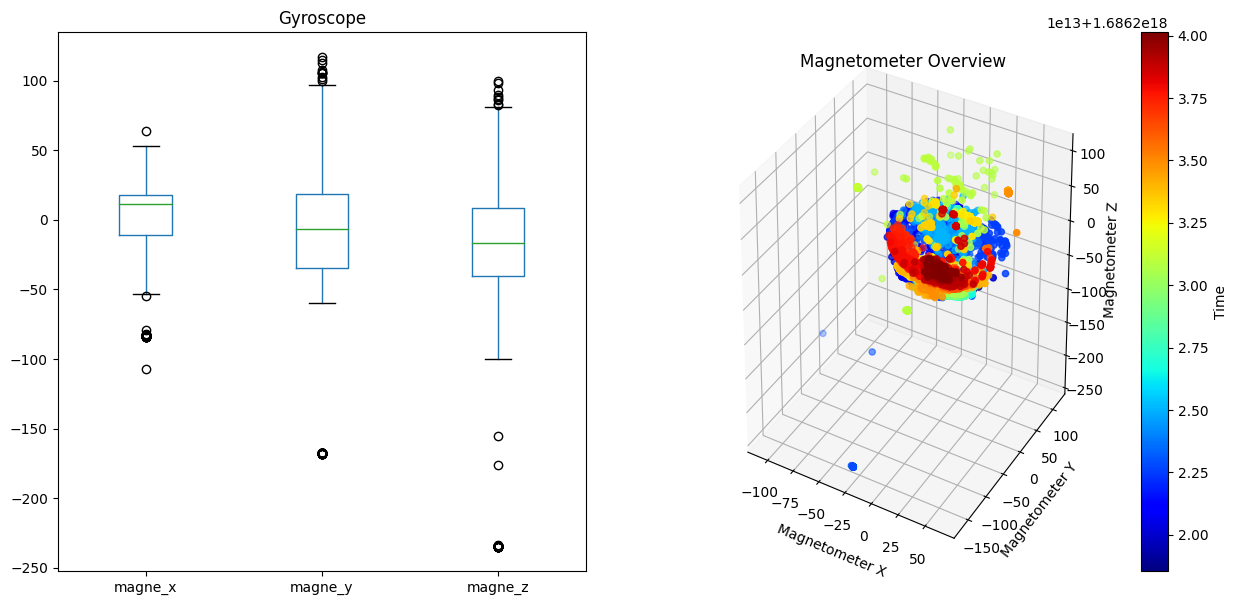

In [8]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# -------- Box plot
dataset[['magne_x', 'magne_y', 'magne_z']].plot.box(ax=ax1)
ax1.set_title("Gyroscope")

# -------- Scatter plot
ax2.scatter(
    dataset['magne_x'],
    dataset['magne_y'],
    dataset['magne_z'],
    c=pd.to_datetime(dataset['time']).astype(int),
    cmap=cm.jet
)
ax2.set_xlabel('Magnetometer X')
ax2.set_ylabel('Magnetometer Y')
ax2.set_zlabel('Magnetometer Z')
ax2.set_title('Magnetometer Overview')
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Time')
plt.show()

#### Barometer

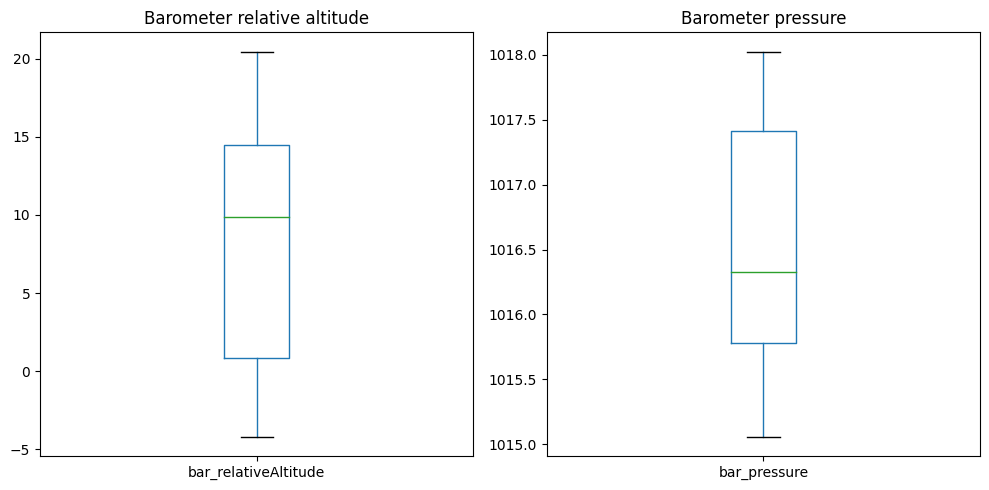

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dataset[["bar_relativeAltitude"]].plot.box(ax=axes[0])
axes[0].set_title("Barometer relative altitude")

dataset[["bar_pressure"]].plot.box(ax=axes[1])
axes[1].set_title("Barometer pressure")

plt.tight_layout()
plt.show()

#### Location

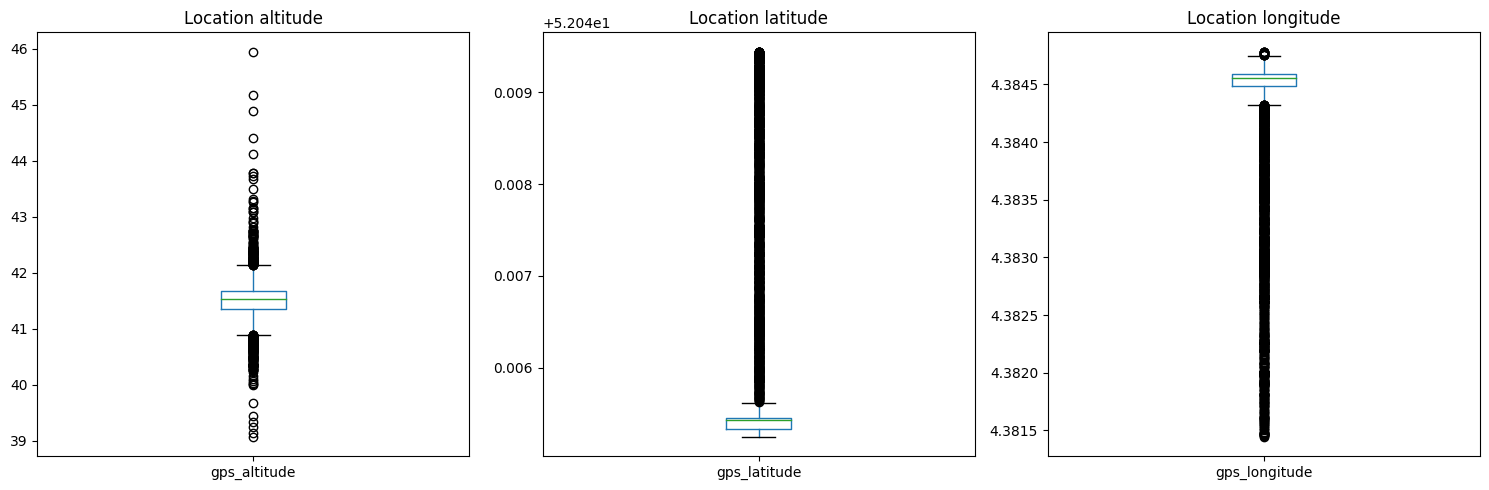

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

dataset[["gps_altitude"]].plot.box(ax=axes[0])
axes[0].set_title("Location altitude")

dataset[["gps_latitude"]].plot.box(ax=axes[1])
axes[1].set_title("Location latitude")

dataset[["gps_longitude"]].plot.box(ax=axes[2])
axes[2].set_title("Location longitude")

plt.tight_layout()
plt.show()

### Outlier removal

In [11]:
def print_missing_values_percentages(dataset: pd.DataFrame):
    nan_percentages_per_column = []
    for column in dataset.columns:
        
        nan_values = dataset[column].isnull().sum()
        
        total_values = dataset.shape[0]
        
        percentages = (nan_values / total_values) * 100
        
        nan_percentages_per_column.append(
            percentages
        )

    sns.barplot(y=nan_percentages_per_column, x=dataset.columns)
    plt.xticks(rotation=90, size=6)
    plt.tight_layout()
    plt.show()

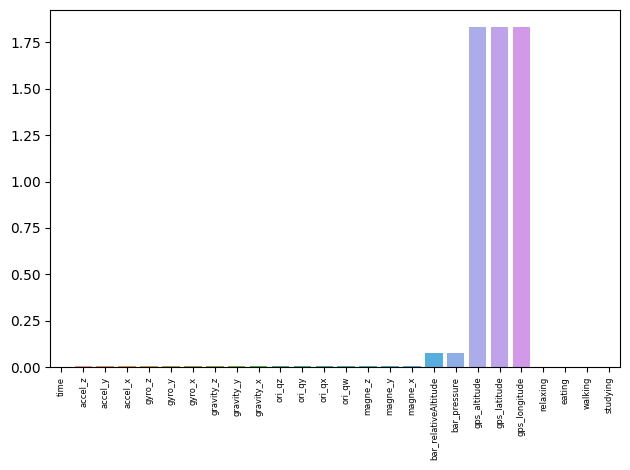

In [12]:
print_missing_values_percentages(dataset)

#### Simple distance based outlier detection

In [1]:
from book.Chapter3.OutlierDetection import DistanceBasedOutlierDetection

d_min = 0.1
f_min = 0.99

OutlierDist = DistanceBasedOutlierDetection()
for col in simple_distance_based_outlier_columns:
    try:
        dataset = OutlierDist.simple_distance_based(
            dataset, [col], 'euclidean', d_min, f_min)
        dataset.loc[dataset['simple_dist_outlier'] == True, col] = None
    except MemoryError as e:
        print(
            'Not enough memory available for simple distance-based outlier detection...')
        print('Skipping.')
dataset = dataset.drop('simple_dist_outlier', axis=1)

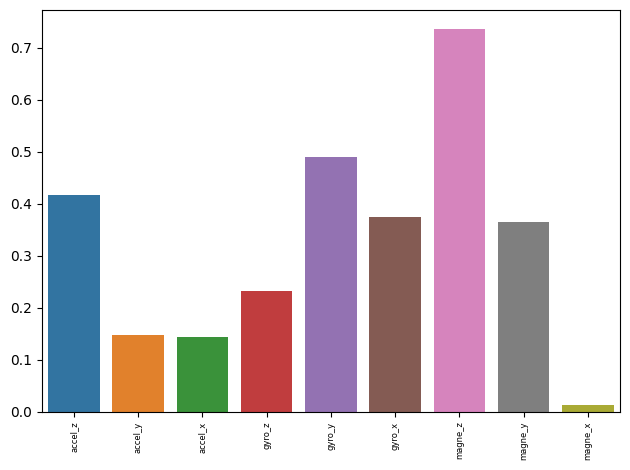

In [15]:
print_missing_values_percentages(dataset[simple_distance_based_outlier_columns])

#### Local outlier factor detection

In [22]:
from book.Chapter3.OutlierDetection import DistanceBasedOutlierDetection

k = 4

OutlierDist = DistanceBasedOutlierDetection()
for col in local_outlier_factor_columns:
    try:
        
        dataset = OutlierDist.local_outlier_factor(
            dataset, [col], 'euclidean', k
        )
        dataset.loc[dataset['lof'] == True, col] = None
    except MemoryError as e:
        print(
            'Not enough memory available for local outlier factor detection...'
        )
        print('Skipping.')
dataset = dataset.drop('lof', axis=1)

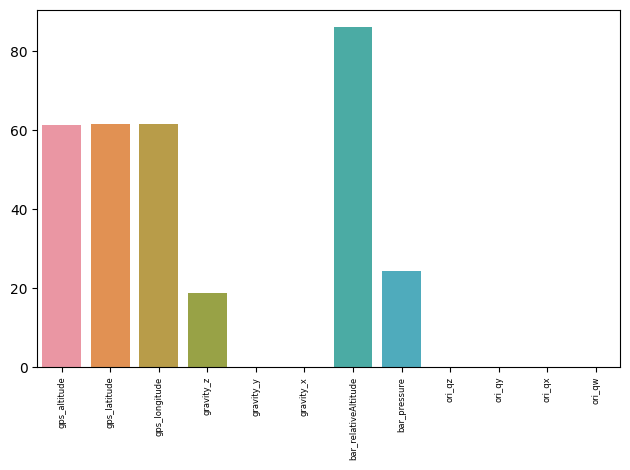

In [16]:
print_missing_values_percentages(dataset[local_outlier_factor_columns])

In [19]:
# simple distance based ~ 5 min
# local outlier factor ~ 133 min
# saving the state for faster further experimentation
dataset.to_csv(f"state/{EXPERIMENT}_after_outlier_removal.csv", index=False)

### Data inputation (Interpolation)

In [22]:
dataset = pd.read_csv(f"state/{EXPERIMENT}_after_outlier_removal.csv")

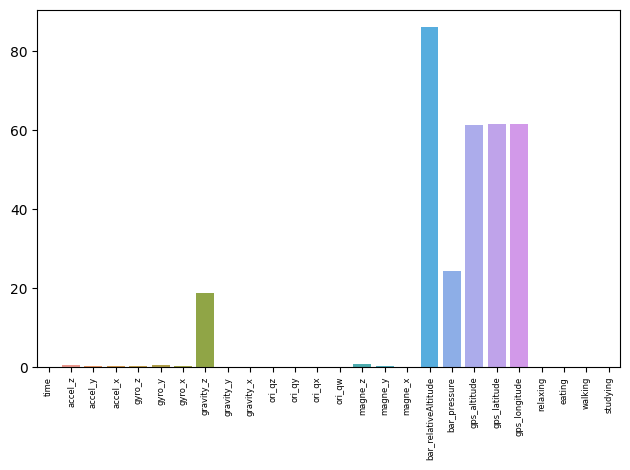

In [23]:
print_missing_values_percentages(dataset)

In [24]:
continuous_features = [
    'accel_z', 'accel_y', 'accel_x',
    'gyro_z', 'gyro_y', 'gyro_x',
    'ori_qz', 'ori_qy', 'ori_qx', 'ori_qw',
    'gps_altitude', 'gps_latitude', 'gps_longitude'
]
dataset[continuous_features] = dataset[continuous_features].interpolate(method='linear', axis=0)

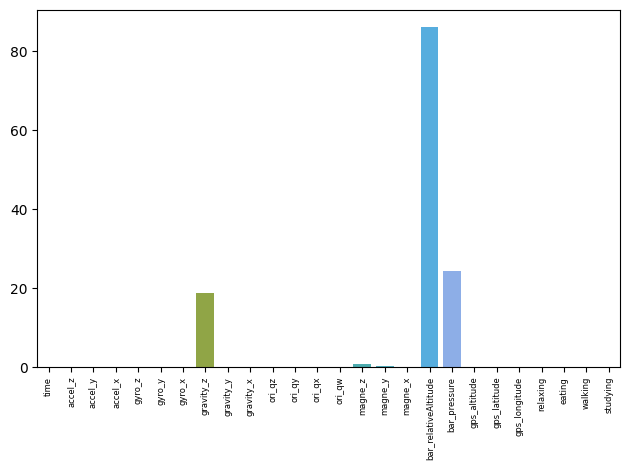

In [25]:
print_missing_values_percentages(dataset)

### Data inputation (KNN)

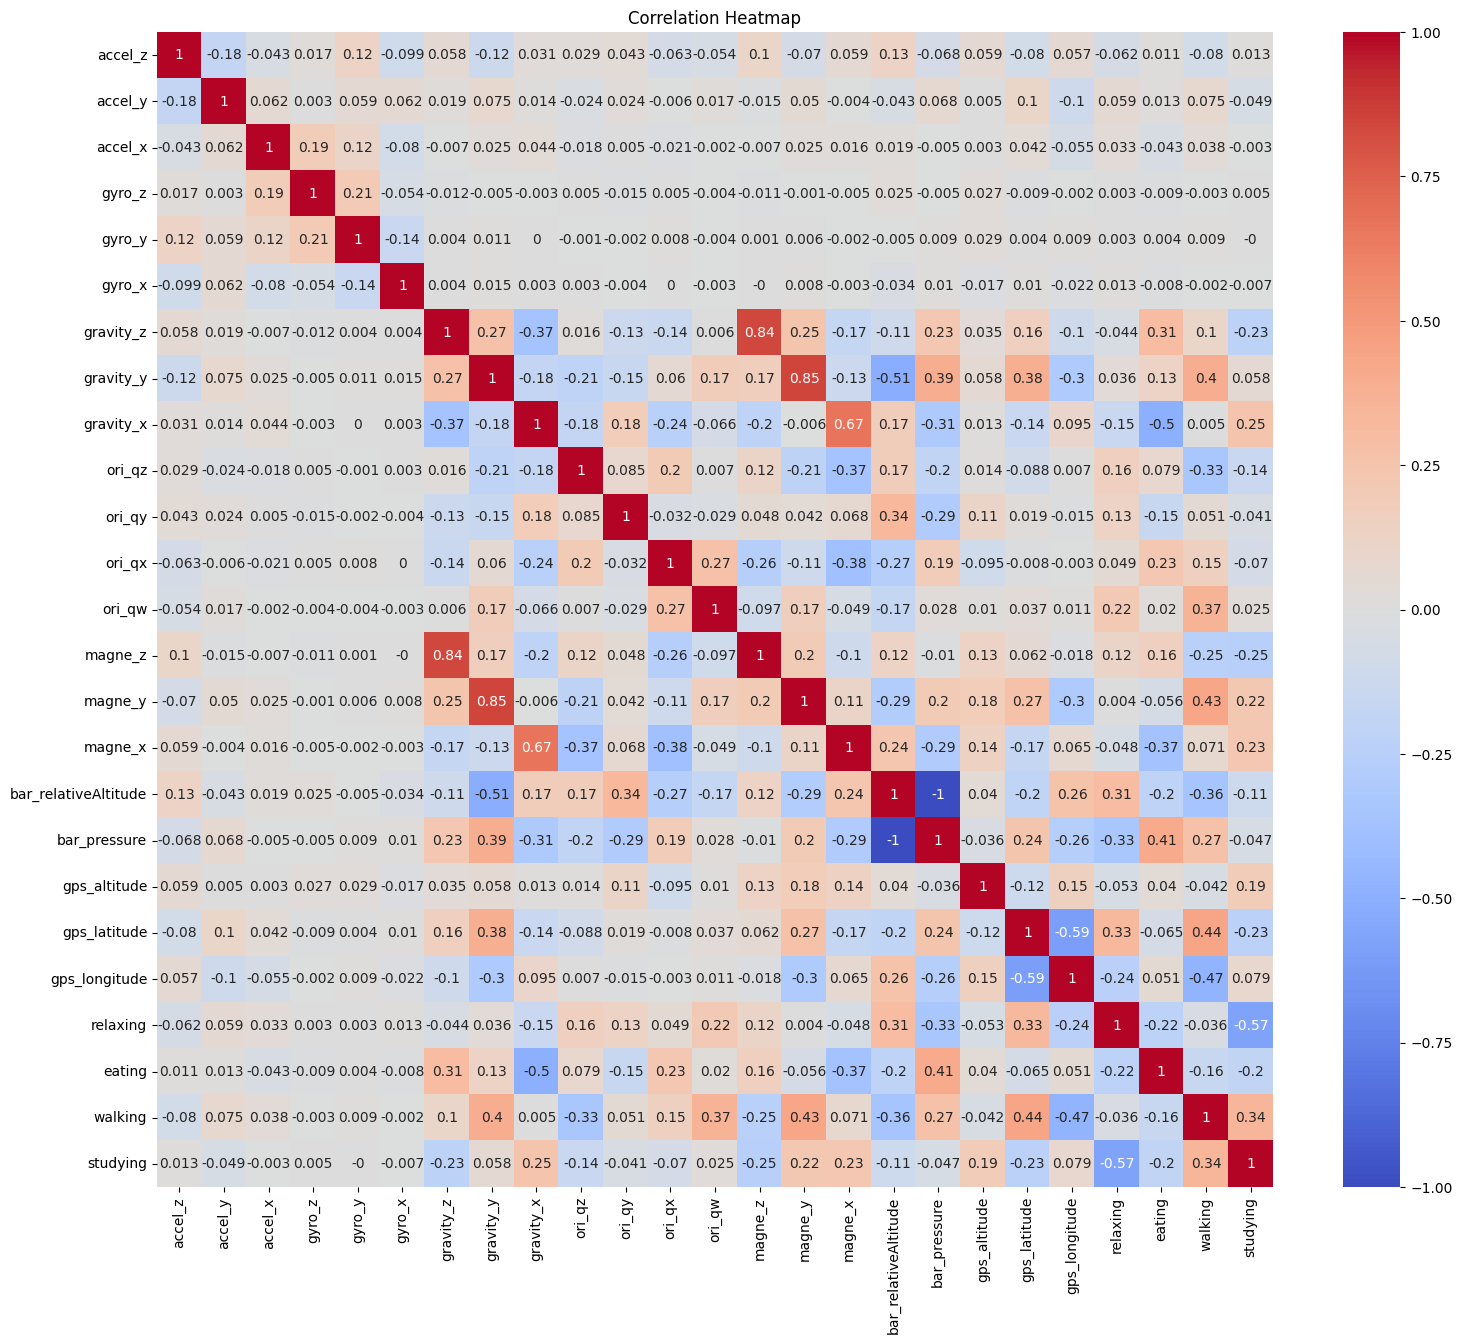

In [26]:
corr_matrix = dataset[0:-4].corr().round(3)
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title and display the plot
plt.title('Correlation Heatmap')
plt.show()

In [40]:
knn_impute = [
    'magne_z', 'magne_y', 'magne_x',
    'bar_relativeAltitude','bar_pressure',
    'gravity_z', 'gravity_y', 'gravity_x'
]

for x in knn_impute:
    selected_features = corr_matrix[corr_matrix[x] > 0.2].index.tolist()
    imputation_columns = selected_features + [x]
    imputation_df = dataset[imputation_columns]
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(imputation_df)
    dataset[x] = imputed_data[:, -1]


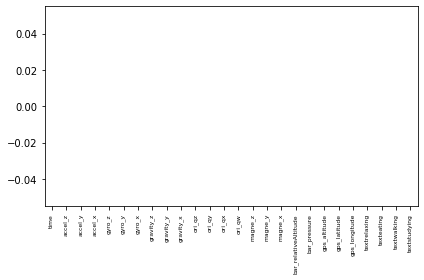

In [42]:
print_missing_values_percentages(dataset)

## Feature engineering part 1: rolling mean/median/std/max/min/slope

Note: we could (un)comment lines depending on what we decide to use. Rolling slope is computationally expensive...

In [17]:
import pandas as pd
import numpy as np
from scipy import stats

window_sizes = [2, 5, 8]

# Exclude time and label columns
for column in dataset[['accel_z', 'accel_y', 'accel_x', 'gyro_z', 'gyro_y', 'gyro_x', 'gravity_z', 'gravity_y',
                        'gravity_x', 'ori_qz', 'ori_qy', 'ori_qx', 'ori_qw', 'magne_z', 'magne_y', 'magne_x', 
                        'bar_relativeAltitude', 'bar_pressure', 'gps_altitude', 'gps_latitude', 'gps_longitude']]:
    for window_size in window_sizes:
        rolling_mean = dataset[column].rolling(window_size).mean()
        rolling_median = dataset[column].rolling(window_size).median()
        rolling_std = dataset[column].rolling(window_size).std()
        rolling_max = dataset[column].rolling(window_size).max()
        rolling_min = dataset[column].rolling(window_size).min()
#         rolling_slope = dataset[column].rolling(window_size).apply(lambda data: np.nan if data.isnull().any() else stats.linregress(range(window_size), data)[0])
        
        new_column_mean_name = f"{column}_rolling_mean_{window_size}"
        new_column_median_name = f"{column}_rolling_median_{window_size}"
        new_column_std_name = f"{column}_rolling_std_{window_size}"
        new_column_max_name = f"{column}_rolling_max_{window_size}"
        new_column_min_name = f"{column}_rolling_min_{window_size}"
#         new_column_slope_name = f"{column}_rolling_slope_{window_size}"
       
        dataset[new_column_mean_name] = rolling_mean
        dataset[new_column_median_name] = rolling_median
        dataset[new_column_std_name] = rolling_std
        dataset[new_column_max_name] = rolling_max
        dataset[new_column_min_name] = rolling_min
#         dataset[new_column_slope_name] = rolling_slope

dataset.head()
